# GB evaluation demo

In [3]:
import corner
import numpy as np
import numpy.lib.recfunctions as recf
import matplotlib.pyplot as plt
import scipy
import xarray as xr

from ldc.lisa.noise import AnalyticNoise
from gb_evaluation import GBEval
from data_tools import mbhb_free_data

In [4]:
workdir = "/home/stefan/LDC/Sangria/evaluation"
gb_apc = GBEval('apc-l2it', workdir, submitted_noise=True)
gb_usa = GBEval('msfc-montana', workdir, submitted_noise=True)
gb_eth = GBEval('eth', workdir, submitted_noise=True)

Submitted files and matched catalogs are saved in a dedicated directory. 

If any issue with the automatic download / unzip, one can manually get the files. 

Working directory should look like this: 

## Noise

Teams are supposed to deliver their noise model.

In [5]:

def get_noise_from_frequency_domain(tdi_fs, number_of_windows=100):
    tdi_ts = xr.Dataset(dict([(k, tdi_fs[k].ts.ifft()) for k in ["X", "Y", "Z"]]))
    dt = tdi_ts.dt
    tdi_ts["A"] = (tdi_ts["Z"] - tdi_ts["X"])/np.sqrt(2.0)
    tdi_ts["E"].values = (tdi_ts["Z"] - 2.0*tdi_ts["Y"] + tdi_ts["X"])/np.sqrt(6.0)
    tdi_ts["T"] = (tdi_ts["Z"] + tdi_ts["Y"] + tdi_ts["X"])/np.sqrt(3.0)
    f, psdA =  scipy.signal.welch(tdi_ts["A"], fs=1.0/dt, nperseg=len(tdi_ts["X"])/number_of_windows)
    f, psdE =  scipy.signal.welch(tdi_ts["E"], fs=1.0/dt, nperseg=len(tdi_ts["X"])/number_of_windows)
    # f2, psdE2 =  scipy.signal.welch(tdi_ts["E"], fs=1.0/dt, nperseg=len(tdi_ts["X"]), scaling='spectrum')
    f, psdT =  scipy.signal.welch(tdi_ts["T"], fs=1.0/dt, nperseg=len(tdi_ts["X"])/number_of_windows)
    return f, psdA, psdE, psdT

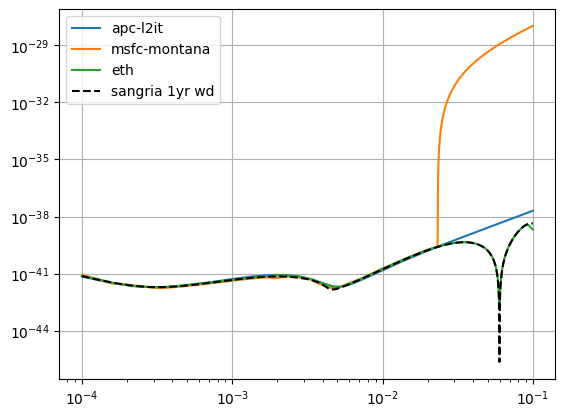

In [6]:
frequencies = np.logspace(-4., -1., 1000)
ldc_noise = AnalyticNoise(frequencies, model="sangria", wd=1)
plt.loglog(frequencies, gb_apc.noise(frequencies), label=gb_apc.team)
plt.loglog(frequencies, gb_usa.noise(frequencies), label=gb_usa.team)
plt.loglog(frequencies, gb_eth.noise(frequencies), label=gb_eth.team)
plt.loglog(frequencies, ldc_noise.psd(frequencies, option='A'), label='sangria 1yr wd', color='k', ls='--')
plt.grid(True)
plt.legend()

## Matched catalogs

Match is done once and saved in the workspace. 

Then, one can apply selection to make specific assessments, on source overlap (ie correlation) and SNR. 

In the example below:
- source pairs with overlap > 0.9 are considered as true detections
- source which don't have any overlappairs with overlap < 0.5 are considered as false detections
- injections with max overlap < 0.5 are considered as missing sources

In [7]:
print(gb_eth.sub_cat['EclipticLongitude'])
gb_apc.load_from_workspace()
gb_usa.load_from_workspace()
gb_eth.load_from_workspace()
print(gb_eth.sub_cat['EclipticLongitude'])

[3.30269882 2.86338367 4.16511496 ... 4.3529228  4.59671583 5.17836459]
[3.30269882 2.86338367 4.16511496 ... 4.3529228  4.59671583 5.17836459]


In [8]:
for gb in [gb_apc, gb_usa, gb_eth]:
    print(gb.team, 'submitted', len(gb.sub_cat), 'matched',len(gb.get_true_detection(injection=True)),'ratio', np.round(len(gb.get_true_detection(injection=True))/ len(gb.sub_cat),2))


apc-l2it submitted 5661 matched 5082 ratio 0.9
msfc-montana submitted 8544 matched 5249 ratio 0.61
eth submitted 7276 matched 6573 ratio 0.9


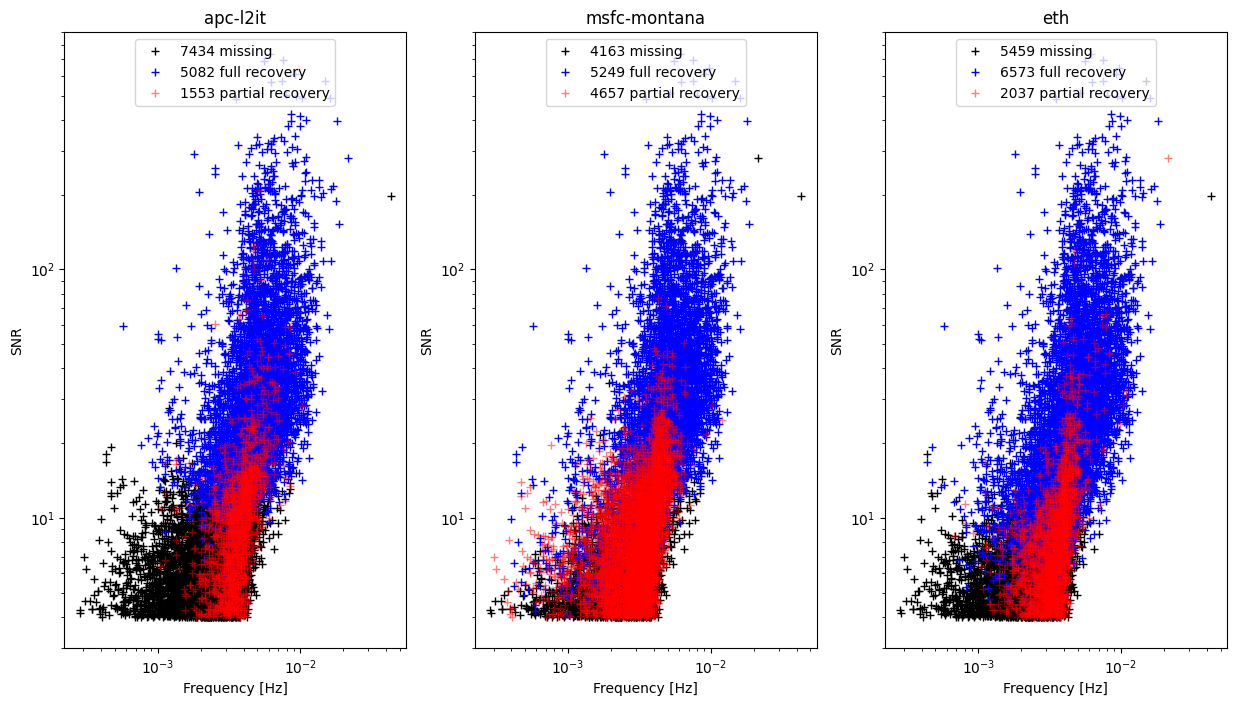

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15,8))
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    axs[j].set_title(gb.team)
    missing = gb.get_missing(thresh=0.1) 
    partial_detection = gb.get_partial_detection(thresh=0.9, injection=True)
    true_detection = gb.get_true_detection(injection=True)
    axs[j].loglog(missing["Frequency"], missing["snr"], "k+", label=f'{len(missing)} missing')
    axs[j].loglog(true_detection["Frequency"], true_detection["snr"], "b+",
                   label=f'{len(true_detection)} full recovery')
    axs[j].loglog(partial_detection["Frequency"], partial_detection["snr"], "r+", alpha=0.5,
                   label=f'{len(partial_detection)} partial recovery')
    axs[j].legend(loc="upper center")
    axs[j].set_xlabel("Frequency [Hz]")
    axs[j].set_ylabel("SNR")    
    axs[j].set_ylim(3, 900)

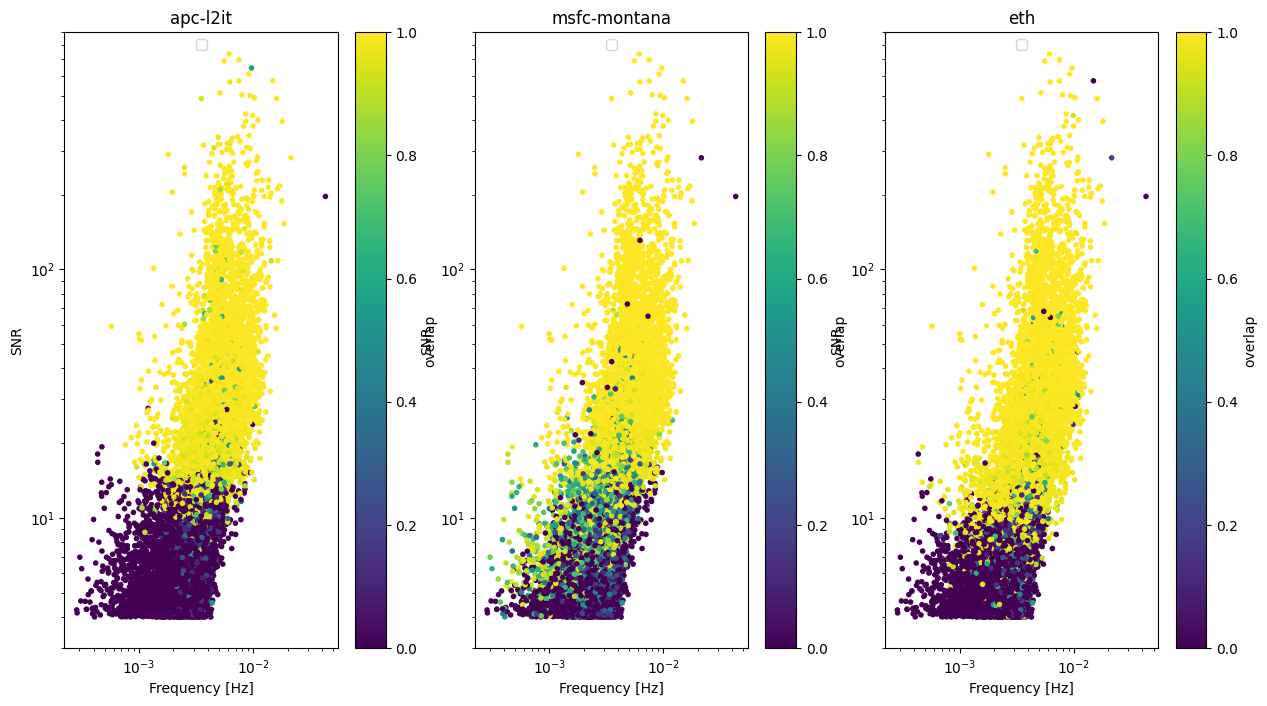

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15,8))
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    axs[j].set_title(gb.team)
    olap = gb.get_max_overlap() 
    sc = axs[j].scatter(gb.inj_cat["Frequency"], gb.inj_cat["snr"], c=olap, marker='.', vmax=1, vmin=0)
    axs[j].legend(loc="upper center")
    axs[j].set_xlabel("Frequency [Hz]")
    fig.colorbar(sc, ax=axs[j], label="overlap")
    axs[j].set_ylabel("SNR")    
    axs[j].set_ylim(3, 900)
    axs[j].set_yscale('log')
    axs[j].set_xscale('log')

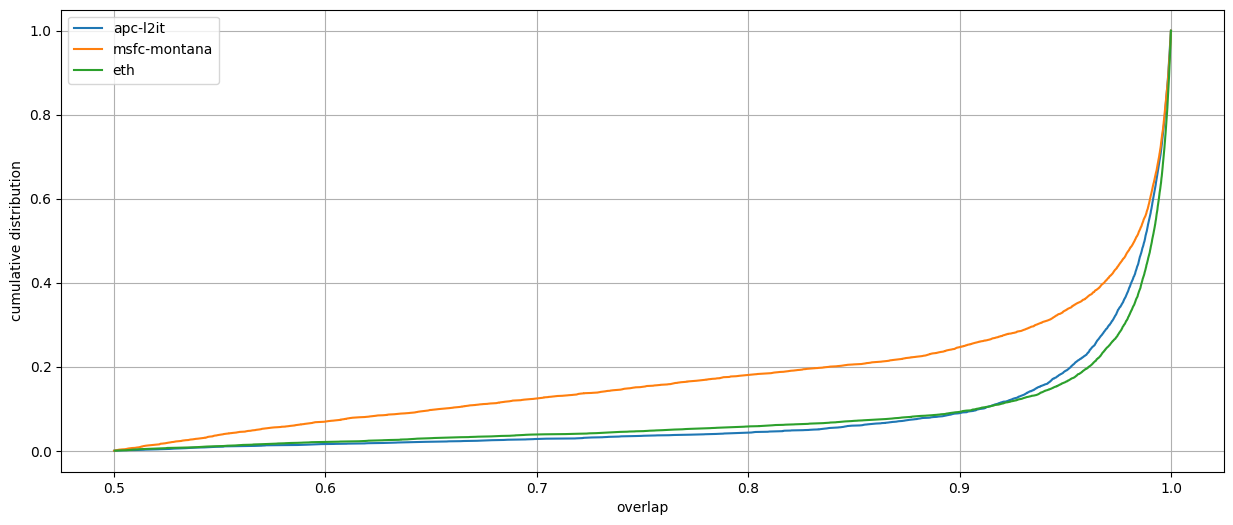

In [32]:

fig, axs = plt.subplots(1,1, figsize=(15,6))

for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    olap = np.array(gb.get_max_overlap())
    olap_high = olap[np.array(olap)>0.5]
    olap_high.sort()
    axs.plot(olap_high, np.arange(len(olap_high))/len(olap_high), label=gb.team)
    # axs.hist(olap_high, histtype=u'step', density=True)
plt.grid(True)
plt.xlabel('overlap')
plt.ylabel('cumulative distribution')
plt.legend()

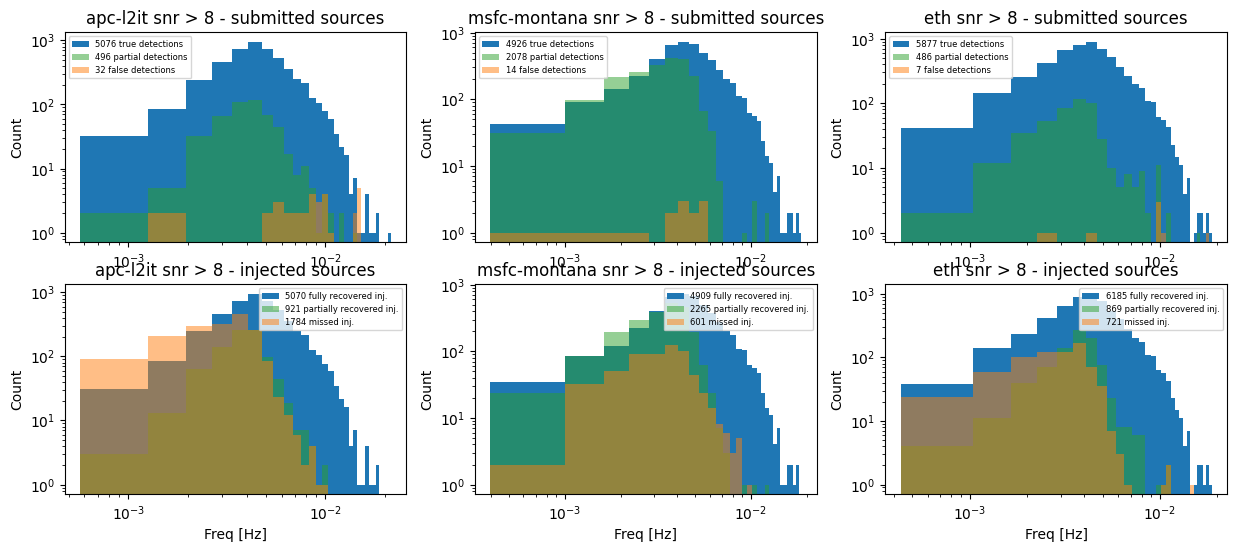

In [12]:
cmap = plt.get_cmap("tab10")
snr_t = 8
fig, axs = plt.subplots(2,3, figsize=(15,6))
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    axs[0][j].set_title(gb.team+f" snr > {snr_t} - submitted sources")
    
    false = gb.get_spurious_detection()
    partial_s = gb.get_partial_detection(thresh=0.9, injection=False)
    true_s = gb.get_true_detection(thresh=0.9, injection=False)
     
    true_s = true_s[true_s['snr']>snr_t]
    false = false[false['snr']>snr_t]
    partial_s = partial_s[partial_s['snr']>snr_t]

    n, bins, patch = axs[0][j].hist(true_s["Frequency"], label=f"{len(true_s)} true detections",
                              bins=30, color=cmap(0))
    axs[0][j].hist(partial_s["Frequency"], bins=bins, label=f"{len(partial_s)} partial detections", alpha=0.5, color=cmap(2))
    axs[0][j].hist(false["Frequency"], bins=bins, label=f"{len(false)} false detections", alpha=0.5, color=cmap(1))
    axs[0][j].set_yscale("log")
    axs[0][j].set_xscale("log")
    axs[0][j].legend(fontsize=6)
    #axs[j][0].set_xlabel("Freq [Hz]")
    axs[0][j].set_ylabel('Count')
    
    axs[1][j].set_title(gb.team+f" snr > {snr_t} - injected sources")
    missing = gb.get_missing(thresh=0.1)
    missing = missing[missing["snr"]>snr_t]
    
    partial_i = gb.get_partial_detection(thresh=0.9, injection=True)
    true_i = gb.get_true_detection(thresh=0.9, injection=True)
    partial_i = partial_i[partial_i['snr']>snr_t]
    true_i = true_i[true_i['snr']>snr_t]
    
    axs[1][j].hist(true_i["Frequency"], bins=bins, label=f"{len(true_i)} fully recovered inj.", color=cmap(0))
    axs[1][j].hist(partial_i["Frequency"], bins=bins, label=f"{len(partial_i)} partially recovered inj.", alpha=0.5, color=cmap(2))
    axs[1][j].hist(missing["Frequency"], bins=bins, label=f"{len(missing)} missed inj.", alpha=0.5, color=cmap(1))
    axs[1][j].set_yscale("log")
    axs[1][j].set_xscale("log")
    axs[1][j].legend(loc="upper right", fontsize=6)
    axs[1][j].set_xlabel("Freq [Hz]")
    axs[1][j].set_ylabel('Count')

100%|██████████| 8544/8544 [08:10<00:00, 17.43it/s]


Text(0, 0.5, 'Count')

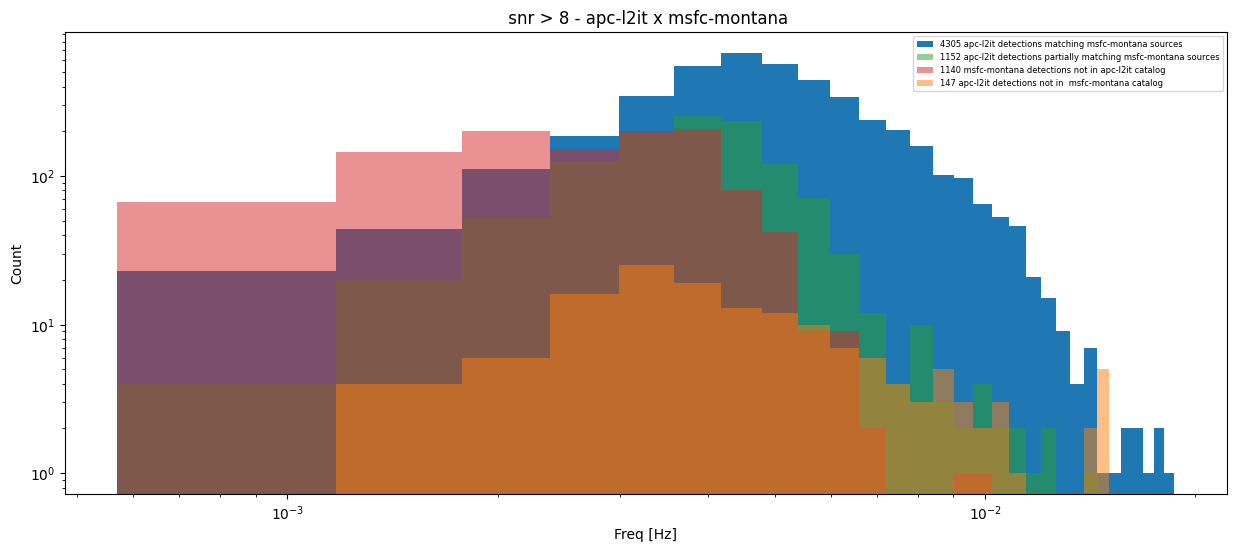

In [9]:
gb_common = GBEval('apc-l2it', workdir, submitted_noise=True)
gb_common.load_from_workspace()
gb_common.inj_cat = gb_usa.sub_cat.copy()
gb_common.match = gb_common.make_match()

cmap = plt.get_cmap("tab10")
snr_t = 8
fig, axs = plt.subplots(1,1, figsize=(15,6))
gb = gb_common
axs.set_title(f" snr > {snr_t} - apc-l2it x msfc-montana")
false = gb.get_spurious_detection()
partial_s = gb.get_partial_detection(thresh=0.9, injection=False)
true_s = gb.get_true_detection(thresh=0.9, injection=False)
true_s = true_s[true_s['snr']>snr_t]
false = false[false['snr']>snr_t]
partial_s = partial_s[partial_s['snr']>snr_t]
missing = gb.get_missing(thresh=0.1)
missing = missing[missing["snr"]>snr_t]
n, bins, patch = axs.hist(true_s["Frequency"],
                          label=f"{len(true_s)} apc-l2it detections matching msfc-montana sources",
                          bins=30, color=cmap(0))
axs.hist(partial_s["Frequency"], bins=bins, 
         label=f"{len(partial_s)} apc-l2it detections partially matching msfc-montana sources", 
         alpha=0.5, color=cmap(2))
axs.hist(missing["Frequency"], bins=bins, label=f"{len(missing)} msfc-montana detections not in apc-l2it catalog", alpha=0.5, color=cmap(3))
axs.hist(false["Frequency"], bins=bins, label=f"{len(false)} apc-l2it detections not in  msfc-montana catalog", alpha=0.5, color=cmap(1))
axs.set_yscale("log")
axs.set_xscale("log")
axs.legend(fontsize=6)
axs.set_xlabel("Freq [Hz]")
axs.set_ylabel('Count')

Text(0, 0.5, 'Count')

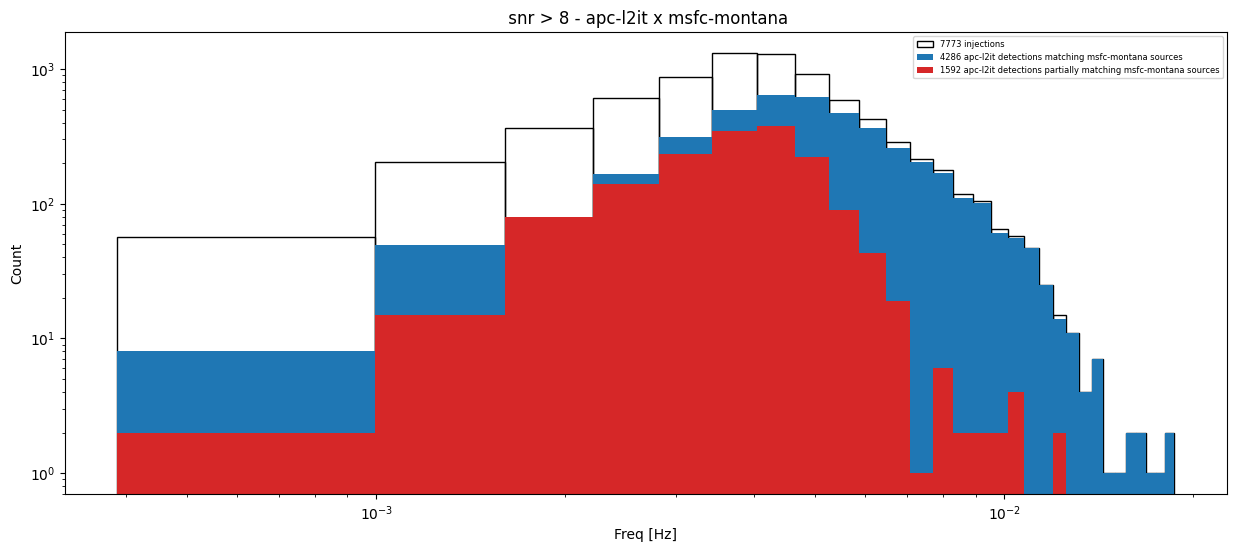

In [10]:
partial_s = gb.get_partial_detection(thresh=0.9, injection=True)
true_s = gb.get_true_detection(thresh=0.9, injection=True)
true_s = true_s[true_s['snr']>snr_t]
partial_s = partial_s[partial_s['snr']>snr_t]
all = gb_apc.inj_cat[gb_apc.inj_cat['snr']>snr_t]
all = all[all["Frequency"]<2e-2] # wrong snr

fig, axs = plt.subplots(1,1, figsize=(15,6))
axs.set_title(f" snr > {snr_t} - apc-l2it x msfc-montana")
n, bins, patch = axs.hist(all["Frequency"], label=f"{len(all)} injections", bins=30, color='grey', fill=False)
axs.hist(true_s["Frequency"], label=f"{len(true_s)} apc-l2it detections matching msfc-montana sources",
         bins=bins, color=cmap(0))
axs.hist(partial_s["Frequency"], bins=bins, 
         label=f"{len(partial_s)} apc-l2it detections partially matching msfc-montana sources", 
         alpha=1, color=cmap(3))#, fill=False)
axs.set_yscale("log")
axs.set_xscale("log")
axs.legend(fontsize=6)
axs.set_xlabel("Freq [Hz]")
axs.set_ylabel('Count')

Text(0, 0.5, 'Count')

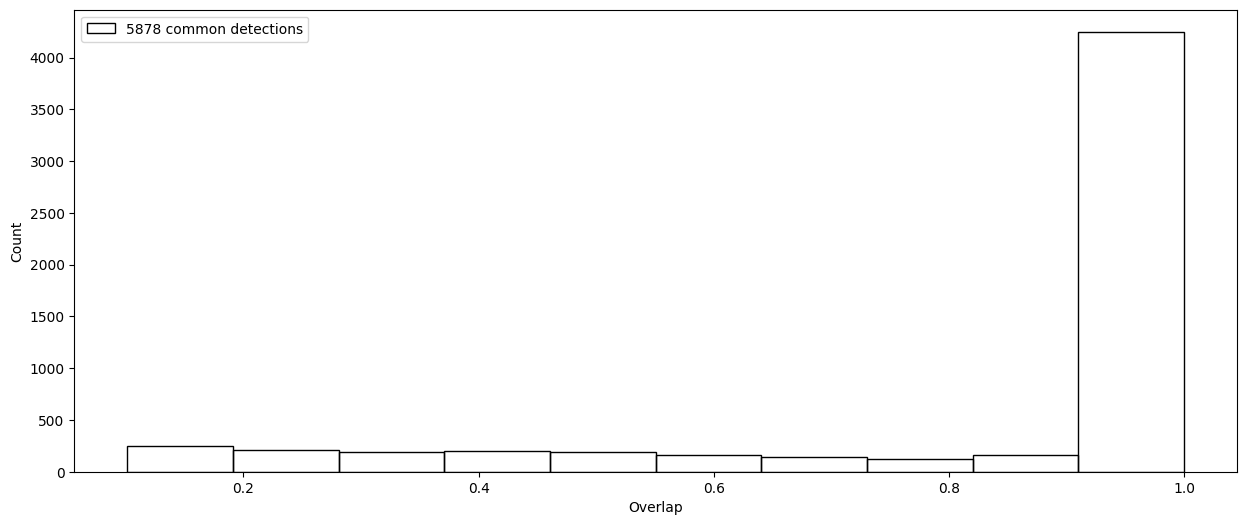

In [11]:
olap = np.array(gb.get_max_overlap())
olap = [o for i_o, o in enumerate(olap)
        if gb_common.inj_cat[i_o] in partial_s or gb_common.inj_cat[i_o] in true_s]
#olap = olap[olap>0]
fig, axs = plt.subplots(1,1, figsize=(15,6))
plt.hist(olap, bins=10, fill=False, color='grey',label=f"{len(olap)} common detections")
#axs.set_yscale("log")
axs.set_xlabel("Overlap")
axs.legend()
axs.set_ylabel('Count')

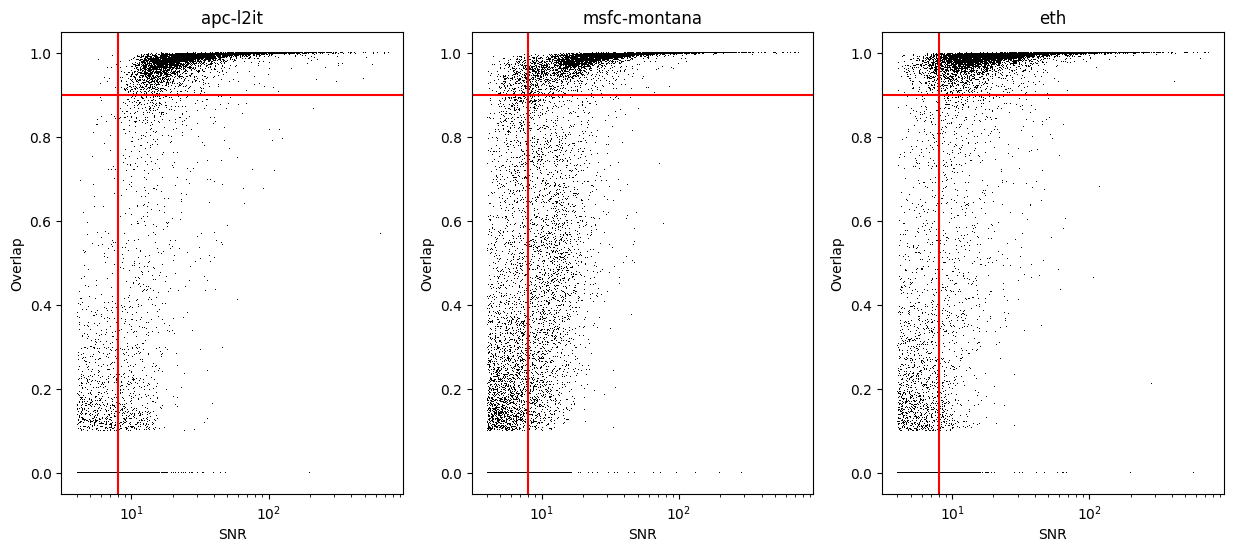

In [9]:
fig, axs = plt.subplots(1,3, figsize=(15,6))
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    axs[j].set_title(gb.team)
    max_olap = gb.get_max_overlap()
    axs[j].plot(gb.inj_cat["snr"], max_olap, 'k,')
    axs[j].set_xlabel("SNR")
    axs[j].set_ylabel("Overlap")
    axs[j].set_xscale("log")
    axs[j].axvline(x=8, color='r')
    axs[j].axhline(y=0.9, color='r')

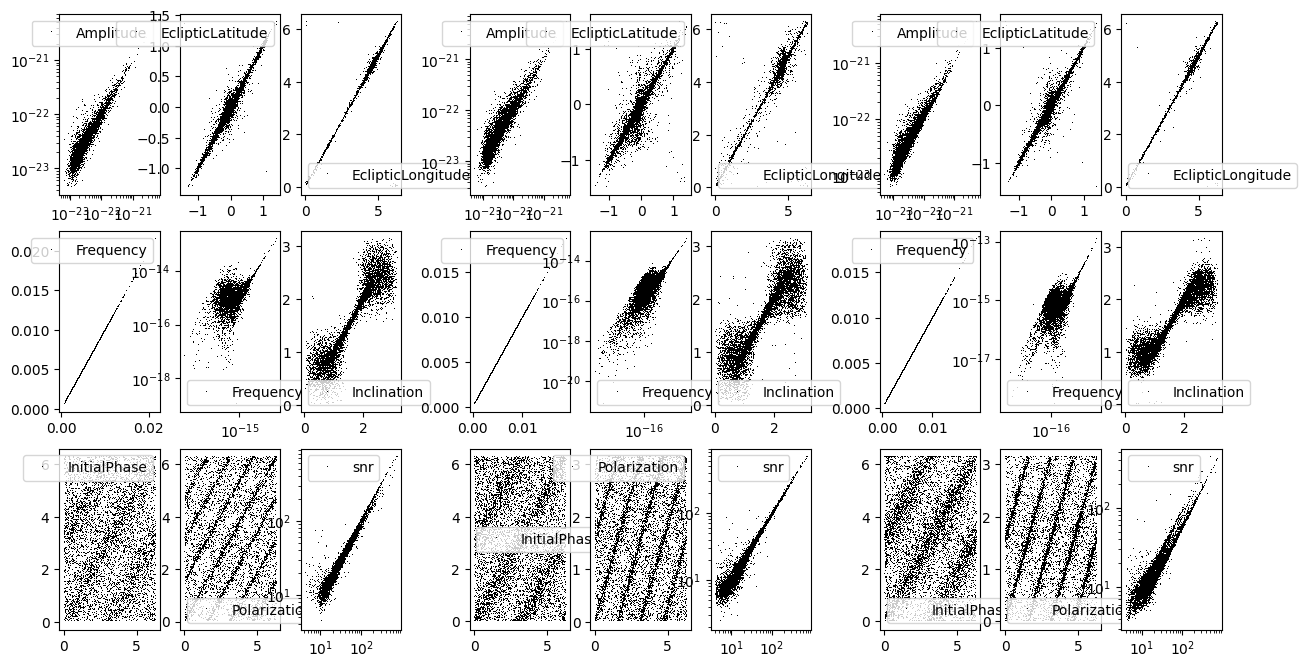

In [13]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 8))
outer = gridspec.GridSpec(1, 3)

for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    inner = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=outer[j])
    #axs[j].set_title(gb.team)
    inj, sub = gb.get_single_detection(thresh=0.5)
    for ik, k in enumerate(['Amplitude', 'EclipticLatitude', 'EclipticLongitude',
                            'Frequency', 'FrequencyDerivative', 'Inclination',
                            'InitialPhase', 'Polarization','snr']):
        ax = plt.Subplot(fig, inner[ik])
        #ax.set_ylabel(k)
        ax.plot(inj[k], sub[k], 'k,', label=k)
        ax.legend()
        if k in ['Amplitude', 'FrequencyDerivative', 'snr']:
            ax.set_yscale('log');ax.set_xscale('log')
        fig.add_subplot(ax)

## Low match

In the following plots, we extract low match, ie when 2 injections are recovered by a single source, with different thresholds on the overlap. 

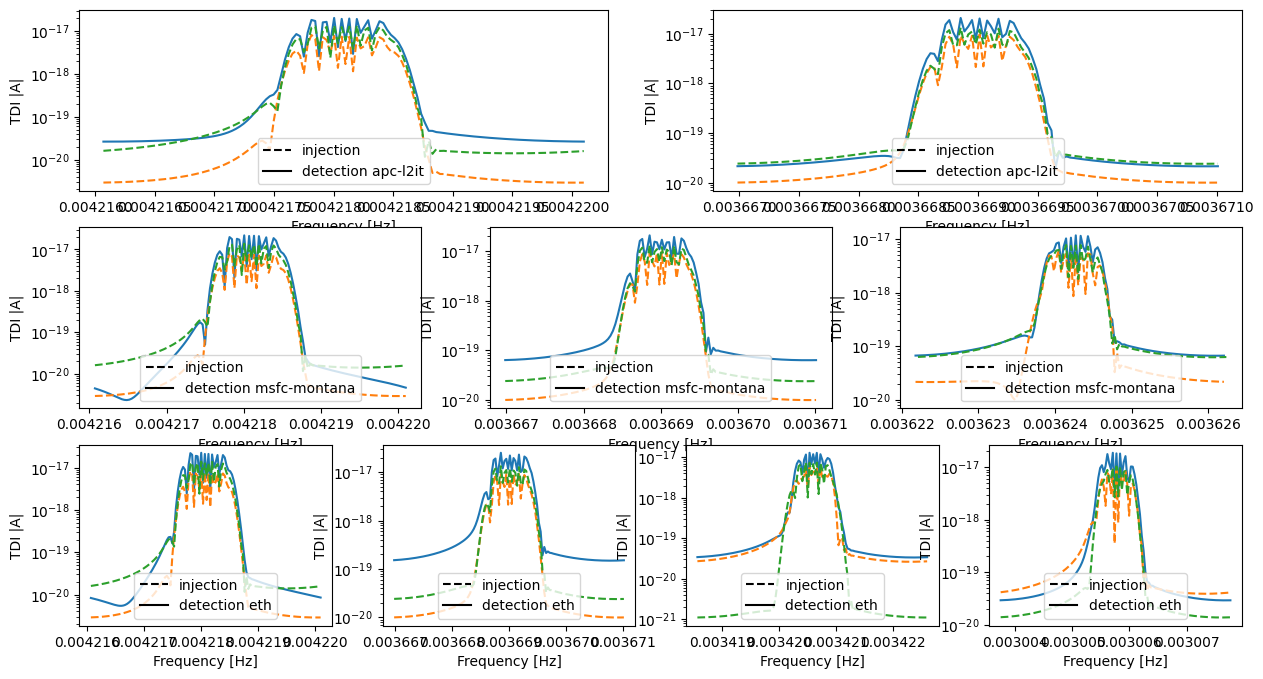

In [14]:
fig = plt.figure(figsize=(15, 8))
outer = gridspec.GridSpec(3, 1)
thresh = 0.9
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    low_match = gb.get_lowmatch(thresh=thresh)
    N = len(low_match.keys())
    inner = gridspec.GridSpecFromSubplotSpec(1, N, subplot_spec=outer[j])
    for ik,(k,v) in enumerate(low_match.items()):
        A,E = gb.get_AE(gb.sub_cat[k])
        ax = plt.Subplot(fig, inner[ik])
        ax.semilogy(A.f, np.abs(A))
        for r in v:
            A,E = gb.get_AE(r)
            ax.semilogy(A.f, np.abs(A), ls='--')
        ax.plot([A.f[0]], [np.abs(A)[0]], label='injection', color='k', ls='--')
        ax.plot([A.f[0]], [np.abs(A)[0]], label=f'detection {gb.team}', color='k', ls='-')
        ax.legend(loc='lower center')
        ax.set_xlabel("Frequency [Hz]")
        ax.set_ylabel("TDI |A|")
        fig.add_subplot(ax)

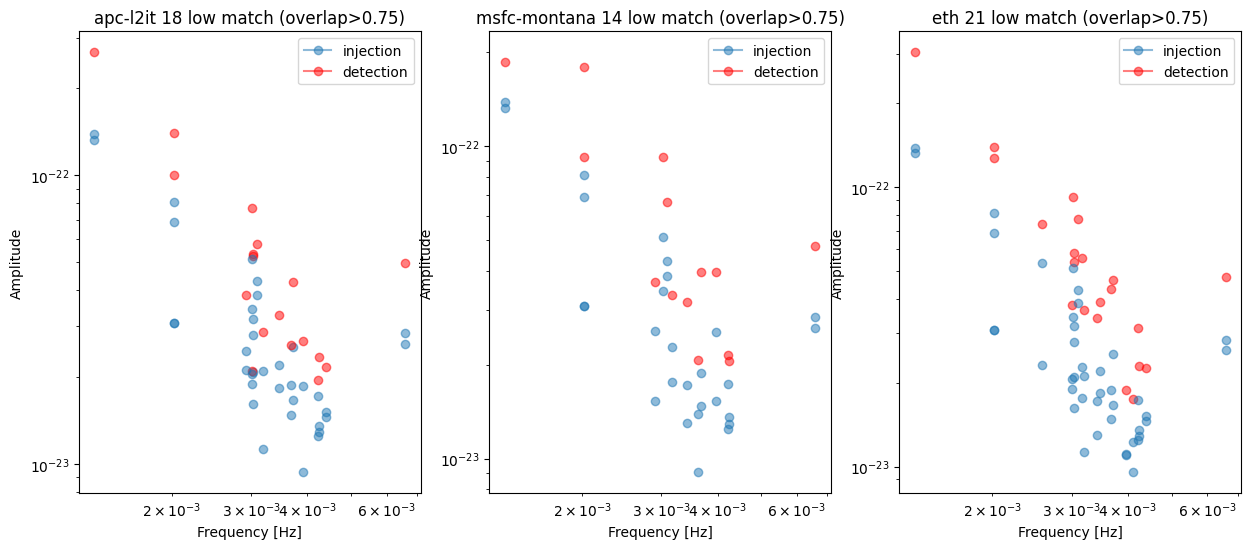

In [15]:
fig, axs = plt.subplots(1,3, figsize=(15,6))
thresh = 0.75
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    low_match = gb.get_lowmatch(thresh=thresh)
    axs[j].set_title(gb.team+f" {len(low_match.keys())} low match (overlap>{thresh})")
    for k,v in low_match.items():
        axs[j].plot(gb.sub_cat["Frequency"][k], gb.sub_cat["Amplitude"][k], 'ro', alpha=0.5)
        for r in v:
            axs[j].loglog(r['Frequency'], r["Amplitude"], ls='None', marker='o', color=cmap(0), alpha=0.5)
    axs[j].plot([0], [2e-22], label='injection', color=cmap(0), marker='o', alpha=0.5)
    axs[j].plot([0], [2e-22], label='detection', color='r', marker='o', alpha=0.5)
    axs[j].legend()
    axs[j].set_xlabel("Frequency [Hz]")
    axs[j].set_ylabel("Amplitude")

## Multi match

In the following plots, we extract multi match, ie when one injection is recovered by a combination of several sources. Again, we test different thresholds on the overlap. 

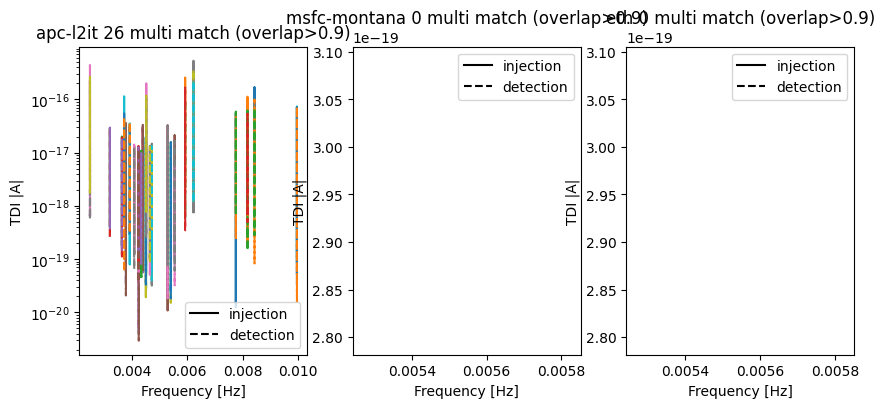

In [16]:
fig, axs = plt.subplots(1,3, figsize=(10,4))
thresh = 0.9
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    multim_inj = gb.get_multimatch(thresh=thresh)
    axs[j].set_title(gb.team+f" {len(multim_inj)} multi match (overlap>{thresh})")
    for k in multim_inj:
        A,E = gb.get_AE(gb.inj_cat[k])
        axs[j].semilogy(A.f, np.abs(A))
        for r in gb.match[k]:
            if r[1]>thresh:
                A,E = gb.get_AE(gb.sub_cat[int(r[0])])
                axs[j].semilogy(A.f, np.abs(A), ls='--')
    axs[j].plot([A.f[0]], [np.abs(A)[0]], label='injection', color='k')
    axs[j].plot([A.f[0]], [np.abs(A)[0]], label='detection', color='k', ls='--')
    axs[j].legend()
    axs[j].set_xlabel("Frequency [Hz]")
    axs[j].set_ylabel("TDI |A|")

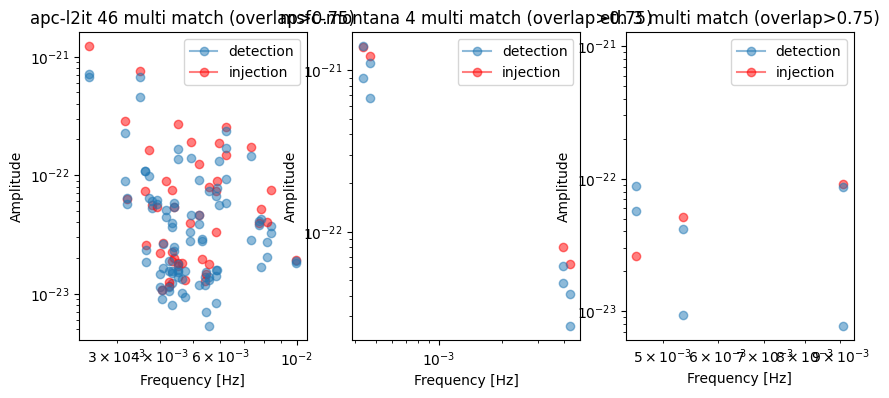

In [17]:
fig, axs = plt.subplots(1,3, figsize=(10,4))
thresh = 0.75
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    multim_inj = gb.get_multimatch(thresh=thresh)
    axs[j].set_title(gb.team+f" {len(multim_inj)} multi match (overlap>{thresh})")
    for k in multim_inj:
        axs[j].plot(gb.inj_cat["Frequency"][k], gb.inj_cat["Amplitude"][k], 'ro', alpha=0.5)
        for r in gb.match[k]:
            if r[1]>thresh:
                A,E = gb.get_AE(gb.sub_cat[int(r[0])])
                axs[j].loglog(gb.sub_cat["Frequency"][int(r[0])], gb.sub_cat["Amplitude"][int(r[0])], 
                              ls='None', marker='o', color=cmap(0), alpha=0.5)
    axs[j].plot([0], [1e-21], label='detection', color=cmap(0), marker='o', alpha=0.5)
    axs[j].plot([0], [1e-21], label='injection', color='r', marker='o', alpha=0.5)
    axs[j].legend()
    axs[j].set_xlabel("Frequency [Hz]")
    axs[j].set_ylabel("Amplitude")

## Posteriors

In [3]:
def plot_posteriors(i_inj):
    names = ['Amplitude', 'Inclination', 'EclipticLatitude', 'EclipticLongitude',
             'Frequency', 'FrequencyDerivative']
    # pdf_apc = gb_apc.get_pdf(i_inj=i_inj)[names]
    pdf_usa = gb_usa.get_pdf(i_inj=i_inj)[names]
    # pdf_eth = gb_eth.get_pdf(i_inj=i_inj)[names]
    truth = np.array([gb_apc.inj_cat[n][i_inj] for n in names])
    fig = plt.figure(figsize=(10,3))
    subfigs = fig.subfigures(1, 3, wspace=0.07)
    for j, (n1, n2) in enumerate([('Amplitude', 'Inclination'),('EclipticLatitude', 'EclipticLongitude'),
                   ('Frequency', 'FrequencyDerivative')]):
        i_n1 = names.index(n1)
        i_n2 = names.index(n2)

        sfig = corner.corner(recf.structured_to_unstructured(pdf_usa[[n1,n2]]),
                            bins=50, hist_kwargs={'density':True, 'lw':3}, 
                            plot_datapoints=False,
                            fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                            show_titles=True, label_kwargs={"fontsize": 6},
                            color='darkcyan', truths=truth[[i_n1, i_n2]], truth_color='k', use_math_test=True,
                            levels=[0.9], title_kwargs={"fontsize": 6}, labels=[n1,n2],fig=subfigs[j])
        sfig = corner.corner(recf.structured_to_unstructured(pdf_usa[[n1,n2]]),
                            bins=50, hist_kwargs={'density':True, 'lw':3}, 
                            plot_datapoints=False,
                            fill_contours=False, quantiles=[0.05, 0.5, 0.95],
                            show_titles=True, label_kwargs={"fontsize": 6},
                            color='red', truths=truth[[i_n1, i_n2]], truth_color='k', use_math_test=True,
                            levels=[0.9], title_kwargs={"fontsize": 6}, labels=[n1,n2],
                            fig=sfig)
        # sfig = corner.corner(recf.structured_to_unstructured(pdf_eth[[n1,n2]]),
        #                     bins=50, hist_kwargs={'density':True, 'lw':3}, 
        #                     plot_datapoints=False,
        #                     fill_contours=False, quantiles=[0.05, 0.5, 0.95],
        #                     show_titles=True, label_kwargs={"fontsize": 6},
        #                     color='blue', truths=truth[[i_n1, i_n2]], truth_color='k', use_math_test=True,
        #                     levels=[0.9], title_kwargs={"fontsize": 6}, labels=[n1,n2],
        #                     fig=sfig)


Init the memory cache
(lisacattools.utils._read_chain_file:130) 2023-04-12 10:31:22,310 INFO utils newfunc Init the memory cache
Cache LDC0082191188-UCB_chains_100s.h5
(lisacattools.utils._read_chain_file:133) 2023-04-12 10:31:22,311 INFO utils newfunc Cache LDC0082191188-UCB_chains_100s.h5
Retrieve LDC0082191188-UCB_chains_100s.h5 from cache
(lisacattools.utils._read_chain_file:125) 2023-04-12 10:31:22,343 INFO utils newfunc Retrieve LDC0082191188-UCB_chains_100s.h5 from cache


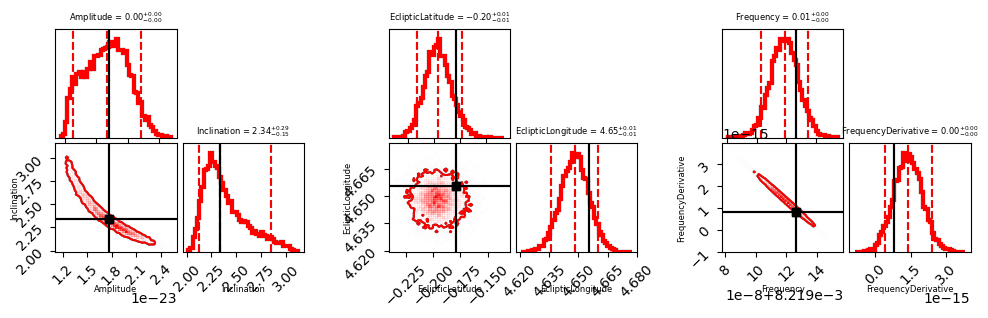

In [6]:
plot_posteriors(1)

Init the memory cache
(lisacattools.utils._read_chain_file:130) 2023-01-31 12:38:26,240 INFO utils newfunc Init the memory cache
Cache LDC0085401275-UCB_chains_0s.h5
(lisacattools.utils._read_chain_file:133) 2023-01-31 12:38:26,242 INFO utils newfunc Cache LDC0085401275-UCB_chains_0s.h5
Retrieve LDC0085401275-UCB_chains_0s.h5 from cache
(lisacattools.utils._read_chain_file:125) 2023-01-31 12:38:26,305 INFO utils newfunc Retrieve LDC0085401275-UCB_chains_0s.h5 from cache


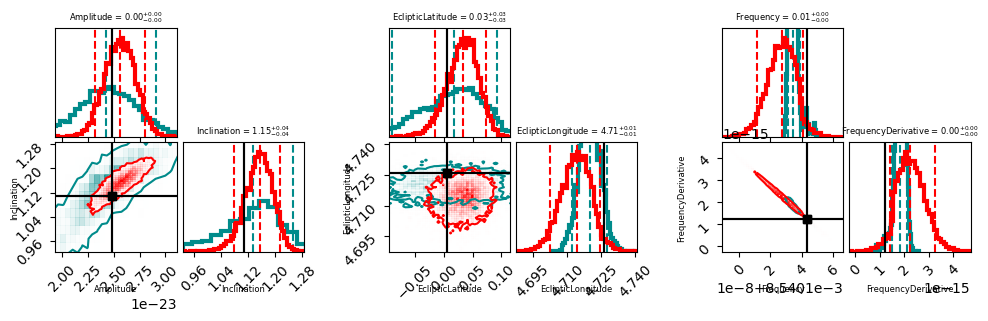

In [ ]:
plot_posteriors(6)

## Residuals

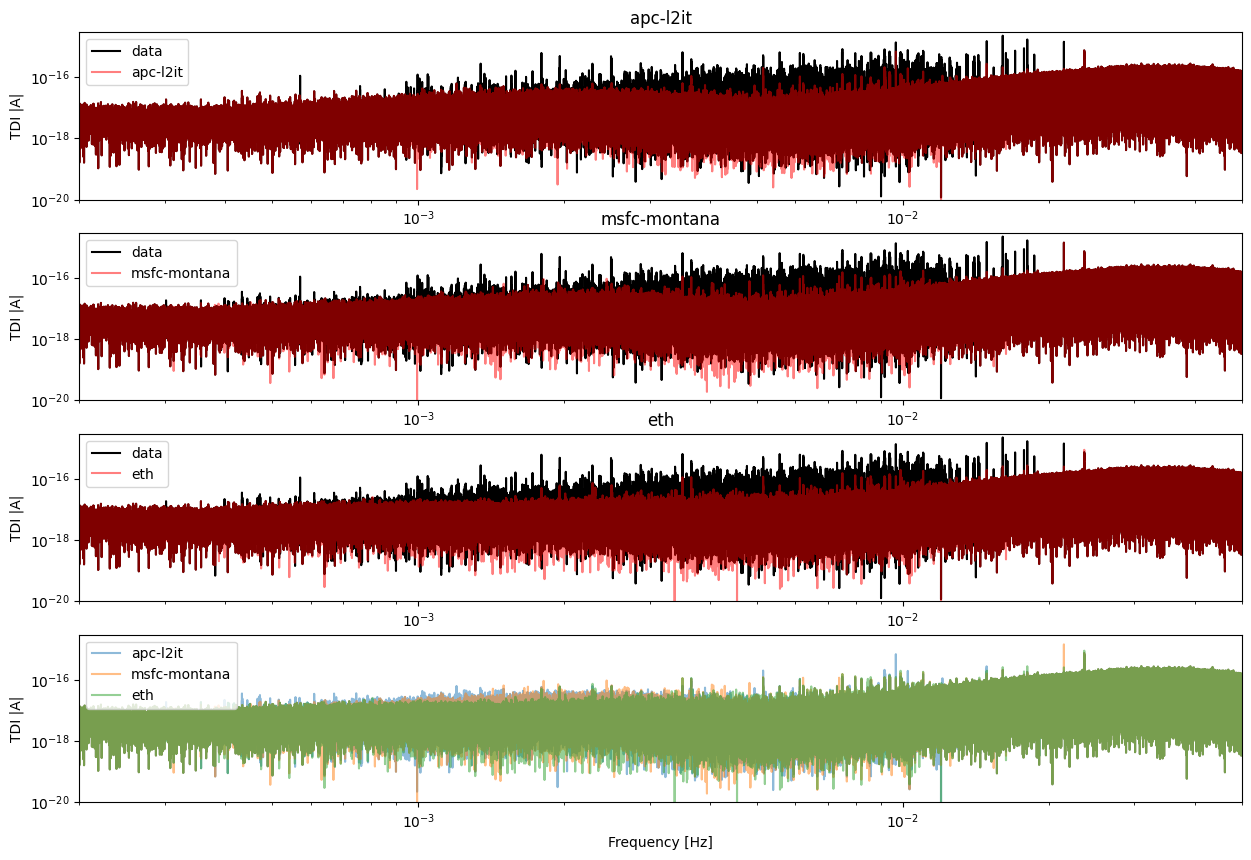

In [19]:
import os
sangria_fn = os.path.join(workdir, 'LDC2_sangria_training_v2.h5')
cmap = plt.get_cmap("tab10")
fig, axs = plt.subplots(4,1, figsize=(15,10))
for j, gb in enumerate([gb_apc, gb_usa, gb_eth]):
    tdidata = mbhb_free_data(sangria_fn)
    axs[j].set_title(gb.team)
    axs[j].loglog(tdidata.f, np.abs(tdidata.A), 'k-', label='data')
    for s in gb.sub_cat:
        A,E = gb.get_AE(s, oversample=4)
        kmin = A.attrs['kmin']
        tdidata.A.values[kmin:kmin+len(A.values)]-= A.values

    axs[j].loglog(tdidata.A.f, np.abs(tdidata.A), 'r-', alpha=0.5, label=gb.team)
    axs[j].set_ylabel("TDI |A|")
    axs[j].set_xlim(2e-4, 5e-2)
    axs[j].set_ylim(1e-20, 3e-15)
    axs[j].legend(loc="upper left")
    
    axs[-1].loglog(tdidata.A.f, np.abs(tdidata.A), color=cmap(j), alpha=0.5,
                       label=gb.team)
axs[-1].set_xlabel("Frequency [Hz]")
axs[-1].set_ylabel("TDI |A|")
axs[-1].set_xlim(2e-4, 5e-2)
axs[-1].set_ylim(1e-20, 3e-15)
axs[-1].legend(loc="upper left")
